In [10]:
import numpy as np
import pandas as pd
import os
import random
import scipy.optimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import errno

In [45]:
# useful definitions
G = 6.67*10**-11
c = 3*10**8
M_sun = 2*10**30
R_sun = 6.975*10**8
def M_to_R(m):   # returns Schwarzschild radius in units of R_sun
    return 2*G*m*M_sun / (c**2) / R_sun
def mu(m1,m2):
    return (m1*m2)/(m1+m2)
def Mtot(m1,m2):
    return m1+m2
def period(a,M):
    return 2.*np.pi*np.sqrt(a**3./M)
def r_peri(a_i,e):
    return a_i*(1.-e)
def r_apo(a_i,e):
    return a_i*(1+e)
def r_mu(a,e,p):
    return a*(1-e**2) / (1+e*np.cos(p))
def r_i(r,m_i,M):
    return r*(M-m_i)/M
def v_mu(r_sep,a,M):
    return np.sqrt(M*(2./r_sep - 1./a))
def v_i(r_sep,a,m_i,M):
    return np.sqrt((2./r_sep - 1./a)/M)*(M-m_i)
def v_r(a,e,M,f):
    return e*np.sin(f) * np.sqrt(M / (a*(1-e**2)))
def v_phi(a,e,M,r):
    return np.sqrt(M*a*(1-e**2)) / r
def CoM(m,x):
    m = np.asarray(m)
    x = np.asarray(x)
    return (np.sum(m*x))/(np.sum(m))


# rotation matrix
def x_rot(v, theta):
    rot = np.asarray([[1,0,0],[0,np.cos(theta),-np.sin(theta)],[0,np.sin(theta),np.cos(theta)]])
    return np.dot(rot,v)
def y_rot(v, theta): 
    rot = np.asarray([[np.cos(theta),0,np.sin(theta)],[0,1,0],[-np.sin(theta),0,np.cos(theta)]])
    return np.dot(rot,v)
def z_rot(v, theta):
    rot = np.asarray([[np.cos(theta),-np.sin(theta),0],[np.sin(theta),np.cos(theta),0],[0,0,1]])
    return np.dot(rot,v)


# threshold functions
tid_thresh = 10**-5
def v_crit(m11,m12,m21,m22,a1,a2):
    mu_tot = mu(Mtot(m11,m12),Mtot(m21,m22))
    return np.sqrt((1./mu_tot)*((m11*m12/a1)+(m21*m22/a2)))
def r_evolve(m11,m12,m21,m22,a1,e1):
    return (2*Mtot(m11,m12)*Mtot(m21,m22) / (tid_thresh*m11*m12))**(1./3) * a1*(1+e1)


# define sampling functions
def phi_mc():
    q = 2*np.pi*np.random.random()
    return q
def theta_mc():
    q = 2*np.random.random()-1
    return np.arccos(q)
def phase(phi, ecc):
    def teq(E):
        return E - ecc*np.sin(E)-phi
    root = scipy.optimize.broyden1(teq, [1], f_tol=1e-14)[0]
    f = 2 * np.arctan(np.sqrt((1+ecc)/(1-ecc)) * np.tan(root/2))
    if f>=0:
        return f
    else: 
        return f+2*np.pi
def b_from_bmax(b):
    # sample b uniformly in pi*b_max**2
    return b*np.sqrt((np.random.random()))
    
    
# Define directory-generating function
def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise




def write_input(b,bin_idx,trial,PN):
    if PN=='0':
        PN1, PN2, PN25 = 0, 0, 0
    elif PN=='25':
        PN1, PN2, PN25 = 0, 0, 1
    elif PN=='1225':
        PN1, PN2, PN25 = 1, 1, 1
    input_path = 'input_files/cluster_sample/'
    mkdir_p(input_path)
    f = open(input_path+str(bin_idx)+'_'+str(trial)+'.txt', 'w')
    f.write('%i\n\
%i %i %i 1 1000000000 100\n\
0.01 %.2f 3600.0 10.0\n\
%.6f   %.6f\n\
%.6f  %.6f  %.6f\n\
%.6f  %.6f  %.6f\n\
%.6f   %.6f\n\
%.6f  %.6f  %.6f\n\
%.6f  %.6f  %.6f\n\
%.6f   %.6f\n\
%.6f  %.6f  %.6f\n\
%.6f  %.6f  %.6f\n\
%.6f   %.6f\n\
%.6f  %.6f  %.6f\n\
%.6f  %.6f  %.6f'\
    % (b['n'],PN1,PN2,PN25,b['tau'],\
    b['m11'],r_min*M_to_R(b['m11']),b['x11'][0],b['x11'][1],b['x11'][2],b['v11'][0],b['v11'][1],b['v11'][2],\
    b['m12'],r_min*M_to_R(b['m12']),b['x12'][0],b['x12'][1],b['x12'][2],b['v12'][0],b['v12'][1],b['v12'][2],\
    b['m21'],r_min*M_to_R(b['m21']),b['x21'][0],b['x21'][1],b['x21'][2],b['v21'][0],b['v21'][1],b['v21'][2],\
    b['m22'],r_min*M_to_R(b['m22']),b['x22'][0],b['x22'][1],b['x22'][2],b['v22'][0],b['v22'][1],b['v22'][2]))
    f.close()

In [46]:
# Set these accordingly
grid_path = 'cluster_files/cluster_binaries_ini.dat'
fixed_b = True    # boolean to specify if we are reading in cluster data with fixed b
n_part=4
orbits=1000000
trials=5 # this is the number of trials we'll monte carlo over
r_min=1.  # times the sum of Schwarzschild radius, for collisional stop criteria


# save Carl's data into a dataframe
data=pd.read_csv(grid_path, sep=' ', index_col=None)
for key in data: 
    data.rename(index=str, columns={key: key[(key.index(':')+1):]}, inplace=True)

# get impact parameter in R_sun
data['b/(a1+a2)'] = data['b/(a1+a2)']*(data['a1']+data['a2'])
data.rename(index=str, columns={'b/(a1+a2)':'b'}, inplace=True)
# convert AU to R_sun
a_to_r = (1.5e8/6.975e5)
data['a1'] = data['a1']*a_to_r
data['a2'] = data['a2']*a_to_r
data['b'] = data['b']*a_to_r


In [47]:
# Loop over all binaries in the file

# set random seed for reproducibility
random.seed()

print "Out of %i binaries, we are at: " % len(data)
for idx in xrange(len(data)):
    print "   %i" % idx
    binary=data.iloc[idx]
    for t in xrange(trials):
        
        # read in pertinent data
        m11,m12 = binary['m11'],binary['m12']
        M1 = Mtot(m11,m12)
        a1,e1 = binary['a1'],binary['e1']
        m21,m22 = binary['m21'],binary['m22']
        M2 = Mtot(m21,m22)
        a2,e2 = binary['a2'],binary['e2']
        # get the impact parameter by either taking b_max in the cluster case or sampling in the circle for the grid case
        if fixed_b:
            b = binary['b']
        else:
            b = b_from_bmax(b)
            
        # grab our random values
        phi_b = phi_mc()   # depreciated
        theta1, theta2 = theta_mc(), theta_mc()
        phi_p1, phi_p2 = phi_mc(), phi_mc()
        phi_omega1, phi_omega2 = phi_mc(), phi_mc()
        # make sure phase calculation converges...this is hacky
        condition = False
        while not condition:
            try:
                f1, f2 = phase(phi_mc(), e1), phase(phi_mc(), e2)
                condition = True
            except:
                pass

        
        
        # FIRST BINARY
        r1_mag = r_mu(a1,e1,f1)
        v1_mag = v_mu(r1_mag,a1,M1) # for checking against the norm of v12
        # start in CoM frame of particle 1
        x11 = np.asarray([0, 0, 0])
        x12 = np.asarray([r1_mag*np.cos(f1),r1_mag*np.sin(f1),0])
        v11 = np.asarray([0,0,0])
        v12 = np.asarray([-v_r(a1,e1,M1,f1)*np.cos(f1) - v_phi(a1,e1,M1,r1_mag)*np.sin(f1), \
              -v_r(a1,e1,M1,f1)*np.sin(f1) + v_phi(a1,e1,M1,r1_mag)*np.cos(f1), 0])
        
        # get things in the center of mass of first binary 
        x1_CoM = [CoM([m11,m12],[x11[0],x12[0]]),CoM([m11,m12],[x11[1],x12[1]]),CoM([m11,m12],[x11[2],x12[2]])]
        x11_mag = r_i(r1_mag,m11,M1) # for checking against the norm of x11
        x12_mag = r_i(r1_mag,m12,M1) # for checking against the norm of x12
        x11 = x11 - x1_CoM
        x12 = x12 - x1_CoM
        v1_CoM = [CoM([m11,m12],[v11[0],v12[0]]),CoM([m11,m12],[v11[1],v12[1]]),CoM([m11,m12],[v11[2],v12[2]])]
        v11_mag = np.sqrt((2./r1_mag - 1./a1)/M1)*(M1-m11) # for checking against the norm of v11
        v12_mag = np.sqrt((2./r1_mag - 1./a1)/M1)*(M1-m12) # for checking against the norm of v12
        v11 = v11 - v1_CoM
        v12 = v12 - v1_CoM
                
        # rotate binary to randomize periapse angle, inclination, and ascending node
        # rotate about angle of periapse (z-rot):
        x11, x12 = z_rot(x11, phi_p1), z_rot(x12, phi_p1)
        v11, v12 = z_rot(v11, phi_p1), z_rot(v12, phi_p1)
        # rotate about angle of inclination (y-rot):
        x11, x12 = y_rot(x11, theta1), y_rot(x12, theta1)
        v11, v12 = y_rot(v11, theta1), y_rot(v12, theta1)
        # rotate about angle of ascending node (z-rot):
        x11, x12 = z_rot(x11, phi_omega1), z_rot(x12, phi_omega1)
        v11, v12 = z_rot(v11, phi_omega1), z_rot(v12, phi_omega1)


        
        
        
        # SECOND BINARY
        
        r2_mag = r_mu(a2,e2,f2)
        v2_mag = v_mu(r2_mag,a2,M2) # for checking against the norm of v22
        # start in CoM frame of particle 1
        x21 = np.asarray([0, 0, 0])
        x22 = np.asarray([r2_mag*np.cos(f2),r2_mag*np.sin(f2),0])
        v21 = np.asarray([0,0,0])
        v22 = np.asarray([-v_r(a2,e2,M2,f2)*np.cos(f2) - v_phi(a2,e2,M2,r2_mag)*np.sin(f2), \
              -v_r(a2,e2,M2,f2)*np.sin(f2) + v_phi(a2,e2,M2,r2_mag)*np.cos(f2), 0])

        # get things in the center of mass of first binary 
        x2_CoM = [CoM([m21,m22],[x21[0],x22[0]]),CoM([m21,m22],[x21[1],x22[1]]),CoM([m21,m22],[x21[2],x22[2]])]
        x21_mag = r_i(r2_mag,m21,M2) # for checking against the norm of x11
        x22_mag = r_i(r2_mag,m22,M2) # for checking against the norm of x12
        x21 = x21 - x2_CoM
        x22 = x22 - x2_CoM
        v2_CoM = [CoM([m21,m22],[v21[0],v22[0]]),CoM([m21,m22],[v21[1],v22[1]]),CoM([m21,m22],[v21[2],v22[2]])]
        v21_mag = np.sqrt((2./r2_mag - 1./a2)/M2)*(M2-m21) # for checking against the norm of v11
        v22_mag = np.sqrt((2./r2_mag - 1./a2)/M2)*(M2-m22) # for checking against the norm of v12
        v21 = v21 - v2_CoM
        v22 = v22 - v2_CoM
        
        # rotate binary to randomize periapse angle, inclination, and ascending node
        # rotate about angle of periapse (z-rot):
        x21, x22 = z_rot(x21, phi_p2), z_rot(x22, phi_p2)
        v21, v22 = z_rot(v21, phi_p2), z_rot(v22, phi_p2)
        # rotate about angle of inclination (y-rot):
        x21, x22 = y_rot(x21, theta2), y_rot(x22, theta2)
        v21, v22 = y_rot(v21, theta2), y_rot(v22, theta2)
        # rotate about angle of ascending node (z-rot):
        x21, x22 = z_rot(x21, phi_omega2), z_rot(x22, phi_omega2)
        v21, v22 = z_rot(v21, phi_omega2), z_rot(v22, phi_omega2)
        


        # Move binary 2 into CoM frame of binary 1
        v_inf = binary['v/v_crit']*v_crit(m11,m12,m21,m22,a1,a2)
        # we now find the velocity and impact parameter at point where the binaries are separated by r_evolve
        # where r_evolve is the max distance between sys 1 and sys 2 where tidal threshold is reached
        r_start_1 = r_evolve(m11,m12,m21,m22,a1,e1)
        r_start_2 = r_evolve(m21,m22,m11,m12,a2,e2)
        r_start = max([r_start_1,r_start_2])

        v_start = np.sqrt(v_inf**2 + 2*M1/r_start)   # conservation of energy
        b_start = b*v_inf / v_start   # conservation of angular momentum
        d_start = np.sqrt(r_start**2 - b_start**2)
        x_shift = np.asarray([d_start, 0, b_start]) # incorporate impact parameter along the z-axis
        v_shift = np.asarray([-v_start, 0, 0])
        x21, x22 = x21+x_shift, x22+x_shift
        v21, v22 = v21+v_shift, v22+v_shift
        
        
        
        # Almost there...last we move things to the center of mass frame for the two binaries
        x_CoM = [CoM([m11,m12,m21,m22],[x11[0],x12[0],x21[0],x22[0]]), \
                    CoM([m11,m12,m21,m22],[x11[1],x12[1],x21[1],x22[1]]), \
                       CoM([m11,m12,m21,m22],[x11[2],x12[2],x21[2],x22[2]])]
        v_CoM = [CoM([m11,m12,m21,m22],[v11[0],v12[0],v21[0],v22[0]]), \
                    CoM([m11,m12,m21,m22],[v11[1],v12[1],v21[1],v22[1]]), \
                       CoM([m11,m12,m21,m22],[v11[2],v12[2],v21[2],v22[2]])]
        x11, v11 = x11-x_CoM, v11-v_CoM
        x12, v12 = x12-x_CoM, v12-v_CoM
        x21, v21 = x21-x_CoM, v21-v_CoM
        x22, v22 = x22-x_CoM, v22-v_CoM
        
        
        # Calculate average orbital period for two binaries to use for integration time
        T = (period(a1,M1)+period(a2,M2))/2.
        
        # Store binary info in dictionary
        binary_input={'n':n_part, 'tau':orbits*T, 'm11':m11, 'x11':x11, 'v11':v11, 'm12':m12, 'x12':x12, 'v12':v12, \
            'm21':m21, 'x21':x21, 'v21':v21, 'm22':m22, 'x22':x22, 'v22':v22}
        
        write_input(binary_input,idx,t,'1225')
        

# write initial conditions to read when plotting
#f = open('ICs.txt', 'w')
#f.write('m11 m12 m21 m22 a1 a2 e1 e2\n\
#%f %f %f %f %f %f %f %f' % (m11,m12,m21,m22,a1,a2,e1,e2))
#f.close()

Out of 52 binaries, we are at: 
   0
   1
   2
   3
   4
   5
   6
   7
   8
   9
   10
   11
   12
   13
   14
   15
   16
   17
   18
   19
   20
   21
   22
   23
   24
   25
   26
   27
   28
   29
   30
   31
   32
   33
   34
   35
   36
   37
   38
   39
   40
   41
   42
   43
   44
   45
   46
   47
   48
   49
   50
   51


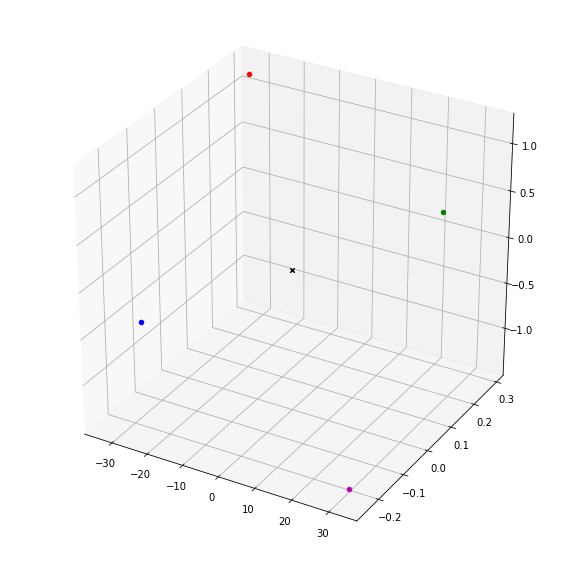

In [90]:
# let's see what these systems look like...
%matplotlib inline
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot((111), projection='3d')

ax.scatter(x11[0], x11[1], x11[2], color='b', label='particle 1')
ax.scatter(x12[0], x12[1], x12[2], color='r', label='particle 2')
ax.scatter(x21[0], x21[1], x21[2], color='g', label='particle 3')
ax.scatter(x22[0], x22[1], x22[2], color='m', label='particle 4')
ax.scatter([0],[0],[0],marker='x',color='k')